In [24]:
epochs = 10

# Federated Learning on MNIST using a CNN

## Imports and Specifications

### Imports

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# check if imports were done properly
print(torch.__version__)
print (torch.cuda.is_available())

1.4.0
True


In [26]:
import syft as sy  # <-- NEW: import the Pysyft library
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker bob
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice

# No secure randomness for this implementation

### Model Params

In [27]:
class Arguments():
    def __init__(self):
        self.batch_size = 256
        self.test_batch_size = 1000
        self.epochs = epochs
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 32
        self.save_model = True

        # DP
        self.using_DP = True

        # train_dp
        self.stddev = 0.1

        # train_dp_2
        self.num_microbatches = 64
        # Clipping Threshold S
        self.S = 1
        # noise_multiplier z
        self.z = 1.1
        self.sigma = self.z * self.S

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

### Data loading and sending to workers
We first load the data and transform the training Dataset into a Federated Dataset split across the workers using the `.federate` method. This federated dataset is now given to a Federated DataLoader. The test dataset remains unchanged.

In [28]:
federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    .federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=args.batch_size, shuffle=True, **kwargs)

In [29]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

### CNN specification
Here we use exactly the same CNN as in the official example.

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Define the train and test functions

For the train function, because the data batches are distributed across `alice` and `bob`, you need to send the model to the right location for each batch. Then, you perform all the operations remotely with the same syntax like you're doing local PyTorch. When you're done, you get back the model updated and the loss to look for improvement.

In [31]:
def train_dp_2(args, model, device, federated_train_loader, optimizer, epoch, using_dp):
    model.train()
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        model.send(data.location) # <-- NEW: send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss(reduction='none')(output, target)
        print(loss)
        
        # diverge from train here
        losses = torch.mean(loss.reshape(4, -1), dim=1)
        saved_var = dict()
        for tensor_name, tensor in model.named_parameters():
            saved_var[tensor_name] = torch.zeros_like(tensor)
        
        for j in losses:
            j.backward(retain_graph=True)
            for p in model.parameters():
                print(p)
                print(p.device)
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.S)
            for tensor_name, tensor in model.named_parameters():
                new_grad = tensor.grad
                saved_var[tensor_name].add_(new_grad)
            model.zero_grad()
            
        for tensor_name, tensor in model.named_parameters():
            if device.type =='cuda':
                noise = torch.cuda.FloatTensor(tensor.grad.shape).normal_(0, args.sigma)
            else:
                noise = torch.FloatTensor(tensor.grad.shape).normal_(0, args.sigma)
            saved_var[tensor_name].add_(noise)
            tensor.grad = saved_var[tensor_name] / num_microbatches
        
        optimizer.step()
        model.get() # <-- NEW: get the model back
        if batch_idx % args.log_interval == 0:
            loss = loss.get() # <-- NEW: get the loss back
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(federated_train_loader) * args.batch_size,
                100. * batch_idx / len(federated_train_loader), loss.item()))

In [32]:
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * test_acc))

    return test_acc, test_loss

### Training Phase

In [33]:
def train_dp(args, model, device, federated_train_loader, optimizer, epoch, using_dp):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        model.send(data.location) # <-- NEW: send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        # for DP
        if(using_dp):
            for p in model.parameters():
                p = p * np.random.normal(loc=1, scale=args.stddev)
        
        pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
        correct += pred.eq(target.view_as(pred)).sum().get()

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        model.get() # <-- NEW: get the model back
        
        # get metrics
        loss = loss.get() # <-- NEW: get the loss back
        train_loss += loss.item() * args.batch_size

        if batch_idx % args.log_interval == 0:
        
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(federated_train_loader) * args.batch_size,
                100. * batch_idx / len(federated_train_loader), loss.item()))
        

    train_loss /= (len(federated_train_loader) * args.batch_size)
    train_acc = correct.item() / (len(federated_train_loader) * args.batch_size)

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, correct, len(federated_train_loader) * args.batch_size,
        100. * train_acc))

    return train_acc, train_loss

In [34]:
variants = ['dp', 'no_dp']
phases = ['test', 'train']
metrics = ['acc', 'loss']
history = {}

for v in variants:
    for p in phases:
        for m in metrics:
            history[f'{p}_{m}_{v}'] = np.zeros((epochs))

print(history)

{'test_acc_dp': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'test_loss_dp': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'train_acc_dp': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'train_loss_dp': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'test_acc_no_dp': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'test_loss_no_dp': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'train_acc_no_dp': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'train_loss_no_dp': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}


In [35]:
def run_experiment(using_DP):
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.lr) # TODO momentum is not supported at the moment
    args.using_DP = using_DP

    dp_suffix = 'dp' if args.using_DP else 'no_dp'
    for epoch in range(1, args.epochs + 1):
        history[f'train_acc_{dp_suffix}'][epoch - 1], history[f'train_loss_{dp_suffix}'][epoch - 1] = train_dp(args, model, device, federated_train_loader, optimizer, epoch, True)
        history[f'test_acc_{dp_suffix}'][epoch - 1], history[f'test_loss_{dp_suffix}'][epoch - 1] = test(args, model, device, test_loader)

    if (args.save_model):
        torch.save(model.state_dict(), f"mnist_cnn_fl{dp_suffix}_.pt")

In [36]:
%%time
run_experiment(using_DP = True)

Train Epoch: 1 [0/60160 (0%)]	Loss: 2.304749
Train Epoch: 1 [8192/60160 (14%)]	Loss: 2.163574
Train Epoch: 1 [16384/60160 (27%)]	Loss: 1.919826
Train Epoch: 1 [24576/60160 (41%)]	Loss: 1.382571
Train Epoch: 1 [32768/60160 (54%)]	Loss: 0.849355
Train Epoch: 1 [40960/60160 (68%)]	Loss: 0.565615
Train Epoch: 1 [49152/60160 (82%)]	Loss: 0.415398
Train Epoch: 1 [57344/60160 (95%)]	Loss: 0.388936

Train set: Average loss: 1.1964, Accuracy: 43536/60160 (72%)


Test set: Average loss: 0.4006, Accuracy: 8794/10000 (88%)

Train Epoch: 2 [0/60160 (0%)]	Loss: 0.387501
Train Epoch: 2 [8192/60160 (14%)]	Loss: 0.396707
Train Epoch: 2 [16384/60160 (27%)]	Loss: 0.290994
Train Epoch: 2 [24576/60160 (41%)]	Loss: 0.328485
Train Epoch: 2 [32768/60160 (54%)]	Loss: 0.351273
Train Epoch: 2 [40960/60160 (68%)]	Loss: 0.240281
Train Epoch: 2 [49152/60160 (82%)]	Loss: 0.322717
Train Epoch: 2 [57344/60160 (95%)]	Loss: 0.229922

Train set: Average loss: 0.3286, Accuracy: 54217/60160 (90%)


Test set: Average loss: 

In [37]:
%%time
run_experiment(using_DP = False)

Train Epoch: 1 [0/60160 (0%)]	Loss: 2.306816
Train Epoch: 1 [8192/60160 (14%)]	Loss: 2.209952
Train Epoch: 1 [16384/60160 (27%)]	Loss: 2.006698
Train Epoch: 1 [24576/60160 (41%)]	Loss: 1.509847
Train Epoch: 1 [32768/60160 (54%)]	Loss: 0.894050
Train Epoch: 1 [40960/60160 (68%)]	Loss: 0.540448
Train Epoch: 1 [49152/60160 (82%)]	Loss: 0.493913
Train Epoch: 1 [57344/60160 (95%)]	Loss: 0.421908

Train set: Average loss: 1.2575, Accuracy: 42789/60160 (71%)


Test set: Average loss: 0.3776, Accuracy: 8897/10000 (89%)

Train Epoch: 2 [0/60160 (0%)]	Loss: 0.377807
Train Epoch: 2 [8192/60160 (14%)]	Loss: 0.471676
Train Epoch: 2 [16384/60160 (27%)]	Loss: 0.397156
Train Epoch: 2 [24576/60160 (41%)]	Loss: 0.296560
Train Epoch: 2 [32768/60160 (54%)]	Loss: 0.331647
Train Epoch: 2 [40960/60160 (68%)]	Loss: 0.219598
Train Epoch: 2 [49152/60160 (82%)]	Loss: 0.303791
Train Epoch: 2 [57344/60160 (95%)]	Loss: 0.407631

Train set: Average loss: 0.3296, Accuracy: 54199/60160 (90%)


Test set: Average loss: 

In [38]:
print(history)

{'test_acc_dp': array([0.8794, 0.9086, 0.9377, 0.9421, 0.9657, 0.9676, 0.9684, 0.9681,
       0.9717, 0.9605]), 'test_loss_dp': array([0.40061026, 0.31573947, 0.20126137, 0.19494458, 0.120392  ,
       0.11065167, 0.10995897, 0.10346482, 0.09432252, 0.1203399 ]), 'train_acc_dp': array([0.72367021, 0.90121343, 0.92865691, 0.94348404, 0.95369016,
       0.96043883, 0.9651762 , 0.96825133, 0.97012965, 0.97219082]), 'train_loss_dp': array([1.19635273, 0.32863163, 0.23513742, 0.18413471, 0.15046994,
       0.12769079, 0.11179291, 0.10036719, 0.09212661, 0.08437015]), 'test_acc_no_dp': array([0.8897, 0.9003, 0.912 , 0.9484, 0.9521, 0.9643, 0.9614, 0.9573,
       0.9752, 0.9739]), 'test_loss_no_dp': array([0.37761111, 0.31010822, 0.27870814, 0.17792605, 0.16131706,
       0.12039221, 0.12437887, 0.13131871, 0.08246789, 0.08338025]), 'train_acc_no_dp': array([0.71125332, 0.90091423, 0.92699468, 0.94185505, 0.9509641 ,
       0.95817819, 0.96319814, 0.96645612, 0.96931516, 0.97224069]), 'train_

## Visualisation

In [39]:
def plot_test_train_graph(dp_suffix, metric):
    '''
    Plots and saves test train graphs for each metric
    using_DP: 'dp', 'no_dp'
    metric: 'acc', 'loss'
    '''

    train_metric = history[f'train_{metric}_{dp_suffix}']
    test_metric = history[f'test_{metric}_{dp_suffix}']
    plt.plot(range(1, len(train_metric) + 1),
                train_metric, label=f'Train {metric}')
    plt.plot(range(1, len(test_metric) + 1), test_metric, label=f'Test {metric}')
    plt.title(f'Test vs Train {metric} for {dp_suffix}')
    plt.ylabel(metric)
    plt.xlabel('No. Epoch')
    plt.legend()
    plt.savefig(
        f'./results/vis_{metric}_{dp_suffix}.png'
    )
    plt.show()
    plt.close()

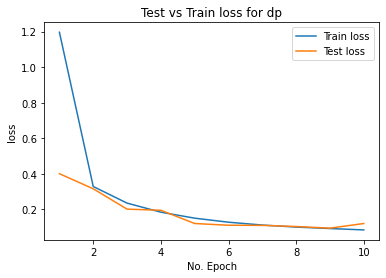

In [40]:
plot_test_train_graph('dp', 'loss')

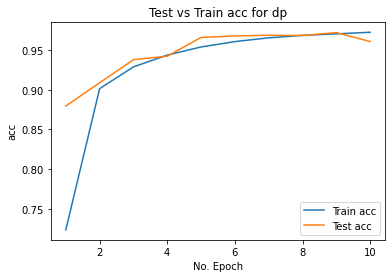

In [41]:
plot_test_train_graph('dp', 'acc')

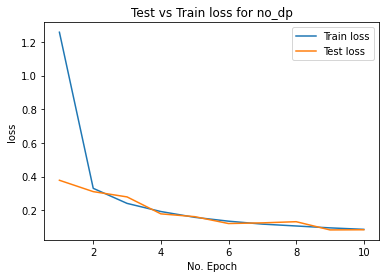

In [42]:
plot_test_train_graph('no_dp', 'loss')

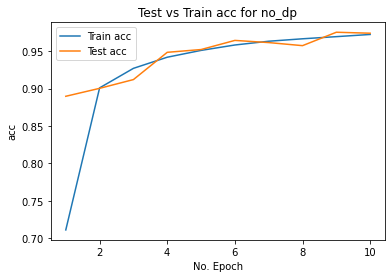

In [43]:
plot_test_train_graph('no_dp', 'acc')

In [44]:

def plot_variants_graph(phase, metric):
    '''
    Plots and saves test train graphs for each metric
    phase: 'test', 'train'
    metric: 'acc', 'loss'
    '''

    dp_metric = history[f'{phase}_{metric}_dp']
    no_dp_metric = history[f'{phase}_{metric}_no_dp']
    plt.plot(range(1, len(dp_metric) + 1),
                dp_metric, label=f'DP {phase} {metric}')
    plt.plot(range(1, len(no_dp_metric) + 1), no_dp_metric, label=f'No DP {phase} {metric}')
    plt.title(f'DP vs no DP {phase} {metric}')
    plt.ylabel(metric)
    plt.xlabel('No. Epoch')
    plt.legend()
    plt.savefig(
        f'./results/dp_comparison_{phase}_{metric}.png'
    )
    plt.show()
    plt.close()

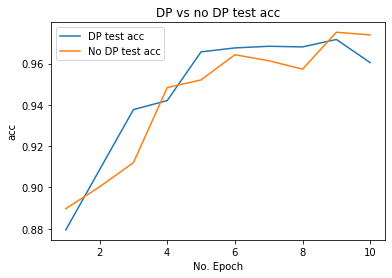

In [45]:
plot_variants_graph('test', 'acc')

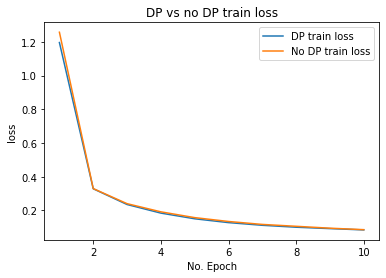

In [46]:
plot_variants_graph('train', 'loss')